# Setup
## Imports

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import matplotlib.pyplot as plt
import json
import pandas as pd
from typing import Optional, Sequence, Iterable

from generative_social_choice.utils.helper_functions import get_base_dir_path
from generative_social_choice.slates.voting_utils import gini
from generative_social_choice.slates.voting_algorithms import VotingAlgorithm
from generative_social_choice.ratings.utility_matrix import extract_voter_utilities_from_info_csv
from generative_social_choice.utils.postprocessing import (
    DEFAULT_COLORS,
    plot_sorted_utility_distributions,
    plot_likert_category_clustered_bar_chart,
    scalar_utility_metrics,
    plot_candidate_distribution_stacked,
    plot_sorted_utility_CIs,
    consolidate_duplicate_columns,
    bootstrap_df_rows,
    plot_scalar_clustered_confidence_intervals,
)
from generative_social_choice.slates.voting_algorithms import (
    GreedyTotalUtilityMaximization,
    ExactTotalUtilityMaximization,
    LPTotalUtilityMaximization,
    ReweightedRangeVoting,
    SequentialPhragmenMinimax,
    ExactTotalUtilityMaximizationBruteSearch,
    GeometricTransformation,
)


## Load data

In [3]:
from generative_social_choice.utils.helper_functions import get_results_paths

LABELLING_MODEL = "4o-mini"

our_pipeline_result_dirs = [get_results_paths(labelling_model=LABELLING_MODEL, baseline=False, run_id=s,  embedding_type="llm")['utility_matrix_file'] for s in range(10)]
our_pipeline_result_dirs

[WindowsPath('G:/Other computers/My Computer/NTFS/dev/generative_social_choice/generative_social_choice/data/results/statements/0/generated_with_4o_using_llm_embeddings/4o-mini_for_labelling/utility_matrix.csv'),
 WindowsPath('G:/Other computers/My Computer/NTFS/dev/generative_social_choice/generative_social_choice/data/results/statements/1/generated_with_4o_using_llm_embeddings/4o-mini_for_labelling/utility_matrix.csv'),
 WindowsPath('G:/Other computers/My Computer/NTFS/dev/generative_social_choice/generative_social_choice/data/results/statements/2/generated_with_4o_using_llm_embeddings/4o-mini_for_labelling/utility_matrix.csv'),
 WindowsPath('G:/Other computers/My Computer/NTFS/dev/generative_social_choice/generative_social_choice/data/results/statements/3/generated_with_4o_using_llm_embeddings/4o-mini_for_labelling/utility_matrix.csv'),
 WindowsPath('G:/Other computers/My Computer/NTFS/dev/generative_social_choice/generative_social_choice/data/results/statements/4/generated_with_4o_

In [4]:
baseline_result_dirs = [get_results_paths(labelling_model=LABELLING_MODEL, baseline=False, run_id=f"fish_{s}",  embedding_type="fish")['utility_matrix_file'] for s in range(10)]
baseline_result_dirs

[WindowsPath('G:/Other computers/My Computer/NTFS/dev/generative_social_choice/generative_social_choice/data/results/statements/fish_0/generated_with_4o_using_fish_embeddings/4o-mini_for_labelling/utility_matrix.csv'),
 WindowsPath('G:/Other computers/My Computer/NTFS/dev/generative_social_choice/generative_social_choice/data/results/statements/fish_1/generated_with_4o_using_fish_embeddings/4o-mini_for_labelling/utility_matrix.csv'),
 WindowsPath('G:/Other computers/My Computer/NTFS/dev/generative_social_choice/generative_social_choice/data/results/statements/fish_2/generated_with_4o_using_fish_embeddings/4o-mini_for_labelling/utility_matrix.csv'),
 WindowsPath('G:/Other computers/My Computer/NTFS/dev/generative_social_choice/generative_social_choice/data/results/statements/fish_3/generated_with_4o_using_fish_embeddings/4o-mini_for_labelling/utility_matrix.csv'),
 WindowsPath('G:/Other computers/My Computer/NTFS/dev/generative_social_choice/generative_social_choice/data/results/stateme

In [5]:
# Load csvs
from pathlib import Path

# Load and merge our pipeline results
dfs_ours = []
for run_id, csv_path in enumerate(our_pipeline_result_dirs):
    df = pd.read_csv(csv_path, index_col=0, header=[0])
    # Create multiindex columns: (run_id, statement_id)
    df.columns = pd.MultiIndex.from_product([[run_id], df.columns], names=['run_id', 'statement_id'])
    dfs_ours.append(df)

# Merge all our pipeline dataframes
df_ours = pd.concat(dfs_ours, axis=1)
df_ours

run_id           0                                                         \
statement_id    s1   s2   s3   s4   s5   s6        s7        s8        s9   
generation1    1.0  2.0  3.0  2.0  3.0  2.0  3.942932  2.840580  3.633299   
generation2    0.0  1.0  3.0  0.0  2.0  0.0  3.778286  2.946926  3.324725   
generation3    4.0  4.0  4.0  0.0  4.0  4.0  3.986486  3.936705  3.935221   
generation4    2.0  1.0  4.0  3.0  2.0  1.0  3.998020  2.813964  3.991555   
generation5    2.0  1.0  4.0  4.0  4.0  2.0  3.989969  3.790196  3.992708   
...            ...  ...  ...  ...  ...  ...       ...       ...       ...   
generation96   4.0  4.0  4.0  1.0  4.0  4.0  3.985740  3.873320  3.996167   
generation97   1.0  2.0  3.0  1.0  3.0  2.0  3.271004  2.944387  3.177310   
generation98   2.0  2.0  4.0  1.0  4.0  2.0  3.967588  3.133832  3.960430   
generation99   3.0  2.0  2.0  2.0  2.0  2.0  3.093474  1.908323  3.386969   
generation100  4.0  2.0  3.0  0.0  4.0  2.0  3.832684  2.951767  3.894737   

run_id                   ...         9                                \
statement_id        s10  ...       s39       s40       s41       s42   
generation1    2.949145  ...  3.609351  3.197353  3.170728  3.828508   
generation2    3.002814  ...  3.670735  3.090738  3.245388  3.499778   
generation3    3.924433  ...  3.993985  3.943741  3.977463  3.996139   
generation4    2.214226  ...  3.989284  3.251406  3.805581  3.984649   
generation5    3.916218  ...  3.967461  3.840784  3.966082  3.984714   
...                 ...  ...       ...       ...       ...       ...   
generation96   3.907693  ...  3.990511  3.951611  3.985165  3.983180   
generation97   2.925313  ...  3.224383  3.002321  3.014461  3.605246   
generation98   3.637952  ...  3.967969  3.736390  3.841854  3.965997   
generation99   2.120680  ...  3.254601  2.689543  2.778984  3.111632   
generation100  3.942743  ...  3.391559  3.768503  3.800592  3.886451   

run_id                                                                     
statement_id        s43       s44       s45       s46       s47       s48  
generation1    2.909827  3.054797  3.657096  3.006715  3.604248  3.215762  
generation2    2.839152  3.001164  3.099498  2.958108  3.432330  3.264613  
generation3    3.916983  3.940950  3.994327  3.944833  3.962288  3.995228  
generation4    3.444030  3.439042  3.971363  2.002482  3.993974  3.988233  
generation5    3.925103  3.938816  3.981071  3.916113  3.989769  3.965867  
...                 ...       ...       ...       ...       ...       ...  
generation96   3.921185  3.893748  3.974451  3.941803  3.974463  3.980517  
generation97   2.938522  2.946576  3.038197  2.968257  3.157370  3.091172  
generation98   3.683667  2.590904  3.984286  3.311317  3.932757  3.987983  
generation99   2.200140  2.081919  2.499701  2.234431  2.713442  3.014619  
generation100  3.355423  3.600714  3.151169  3.487188  3.815436  3.682956  

[100 rows x 480 columns]

In [6]:

# Load and merge baseline results
dfs_baseline = []
for run_id, csv_path in enumerate(baseline_result_dirs):
    df = pd.read_csv(csv_path, index_col=0, header=[0])
    # Create multiindex columns: (run_id, statement_id)
    df.columns = pd.MultiIndex.from_product([[run_id], df.columns], names=['run_id', 'statement_id'])
    dfs_baseline.append(df)

# Merge all baseline dataframes
df_baseline = pd.concat(dfs_baseline, axis=1)

print(f"df_ours shape: {df_ours.shape}")
print(f"df_baseline shape: {df_baseline.shape}")

df_baseline

df_ours shape: (100, 480)
df_baseline shape: (100, 480)


run_id           0                                                         \
statement_id    s1   s2   s3   s4   s5   s6        s7        s8        s9   
generation1    1.0  2.0  3.0  2.0  3.0  2.0  3.606878  2.374456  3.340033   
generation2    0.0  1.0  3.0  0.0  2.0  0.0  3.133320  2.266603  3.291070   
generation3    4.0  4.0  4.0  0.0  4.0  4.0  3.993128  3.886643  3.947126   
generation4    2.0  1.0  4.0  3.0  2.0  1.0  3.997281  1.884515  3.976752   
generation5    2.0  1.0  4.0  4.0  4.0  2.0  3.974187  2.907868  3.985886   
...            ...  ...  ...  ...  ...  ...       ...       ...       ...   
generation96   4.0  4.0  4.0  1.0  4.0  4.0  3.971385  3.815710  3.986407   
generation97   1.0  2.0  3.0  1.0  3.0  2.0  3.012188  1.990670  3.020738   
generation98   2.0  2.0  4.0  1.0  4.0  2.0  3.983599  1.968843  3.960472   
generation99   3.0  2.0  2.0  2.0  2.0  2.0  2.420106  2.017674  2.431835   
generation100  4.0  2.0  3.0  0.0  4.0  2.0  3.311947  3.565987  3.899519   

run_id                   ...         9                                \
statement_id        s10  ...       s39       s40       s41       s42   
generation1    3.496645  ...  2.474659  3.841186  2.877509  2.923776   
generation2    3.541779  ...  2.755765  3.018781  3.004990  2.969787   
generation3    3.986632  ...  3.906482  3.990423  3.917975  3.973903   
generation4    3.918682  ...  2.022967  3.974662  3.076907  2.227909   
generation5    3.990719  ...  3.632825  3.982241  3.968195  3.429931   
...                 ...  ...       ...       ...       ...       ...   
generation96   3.973245  ...  3.949032  3.968847  3.936251  3.932352   
generation97   3.002595  ...  2.110535  2.942924  2.984580  2.467057   
generation98   3.943336  ...  2.027830  3.872548  2.295713  2.290003   
generation99   2.904756  ...  2.015156  2.253268  1.737717  2.030022   
generation100  3.922447  ...  3.484571  3.188023  2.888499  3.537063   

run_id                                                                     
statement_id        s43       s44       s45       s46       s47       s48  
generation1    2.874346  3.305598  1.999577  3.759770  2.968578  3.464279  
generation2    2.913503  3.213426  2.123531  3.758277  2.976942  3.199522  
generation3    3.939382  3.987964  3.879820  3.990560  3.974247  3.984298  
generation4    2.586662  3.934105  1.326481  3.994621  2.229146  3.916668  
generation5    3.179526  3.991991  3.029434  3.975952  3.851411  3.942721  
...                 ...       ...       ...       ...       ...       ...  
generation96   3.895415  3.977688  3.768560  3.985629  3.947697  3.952429  
generation97   2.712076  3.107788  2.000237  3.253274  2.712322  3.045255  
generation98   2.274354  3.987511  1.961220  3.941880  2.000546  3.985485  
generation99   2.125922  2.555855  1.985011  3.310624  2.299399  2.840858  
generation100  3.446954  3.381512  3.014448  3.829959  3.252540  3.799049  

[100 rows x 480 columns]

In [26]:
# Helper Functions for Voting and Plotting

from generative_social_choice.slates.voting_utils import voter_utilities
from typing import Tuple, List, Any, Hashable, Iterable


def run_voting_algorithms(
    utility_df: pd.DataFrame,
    voting_algorithms: Tuple[Any, ...],
    slate_size: int = 5
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Run voting algorithms on a utility dataframe.
    
    Args:
        utility_df: DataFrame with MultiIndex columns (run_id, statement_id)
        voting_algorithms: Tuple of voting algorithm instances to test
        slate_size: Number of statements to select in each slate
        
    Returns:
        Tuple of (df_voter_utilities, df_voter_assignments, df_slates)
    """
    results_data = []
    
    # Iterate through each run in utility_df
    for run_id in utility_df.columns.get_level_values('run_id').unique():
        # Extract utility matrix for this run
        utility_matrix = utility_df[run_id]
        
        # Run each voting algorithm
        for voting_algorithm in voting_algorithms:
            # Run the voting algorithm
            slate, assignments = voting_algorithm.vote(
                rated_votes=utility_matrix.copy(),
                slate_size=slate_size
            )
            
            # Extract voter utilities from assignments
            voter_utilities_series = voter_utilities(
                rated_votes=utility_matrix,
                assignments_series=assignments['candidate_id'],
                output_column_name='utility'
            )
            
            # Store the result with run_id and algorithm name
            results_data.append({
                'run_id': run_id,
                'algorithm': voting_algorithm,
                'utilities': voter_utilities_series,
                'assignments': assignments['candidate_id'],
                'slate': sorted(slate)
            })
    
    # Create dataframe with multiindex columns for voter utilities
    dfs_utilities_list = []
    for result in results_data:
        df_temp = pd.DataFrame({
            (result['run_id'], result['algorithm']): result['utilities']
        })
        df_temp.columns = pd.MultiIndex.from_tuples(
            df_temp.columns, 
            names=['run_id', 'algorithm']
        )
        dfs_utilities_list.append(df_temp)
    
    df_voter_utilities = pd.concat(dfs_utilities_list, axis=1)
    
    # Create dataframe with multiindex columns for voter assignments
    dfs_assignments_list = []
    for result in results_data:
        df_temp = pd.DataFrame({
            (result['run_id'], result['algorithm']): result['assignments']
        })
        df_temp.columns = pd.MultiIndex.from_tuples(
            df_temp.columns, 
            names=['run_id', 'algorithm']
        )
        dfs_assignments_list.append(df_temp)
    
    df_voter_assignments = pd.concat(dfs_assignments_list, axis=1)
    
    # Create dataframe for slates
    slate_data = {}
    for result in results_data:
        col_key = (result['run_id'], result['algorithm'])
        slate_list = list(result['slate']) + [None] * (slate_size - len(result['slate']))
        slate_data[col_key] = slate_list[:slate_size]
    
    df_slates = pd.DataFrame(
        slate_data,
        index=range(slate_size)
    )
    df_slates.columns = pd.MultiIndex.from_tuples(
        df_slates.columns,
        names=['run_id', 'algorithm']
    )
    
    return df_voter_utilities, df_voter_assignments, df_slates


def reorganize_utilities_for_plotting(
    df_voter_utilities: pd.DataFrame
) -> pd.DataFrame:
    """
    Reorganize MultiIndex columns so algorithm is first level, run_id is second.
    
    Args:
        df_voter_utilities: DataFrame with columns (run_id, algorithm)
        
    Returns:
        DataFrame with columns (algorithm, run_id) using display names
    """
    utilities_swapped = df_voter_utilities.copy()
    # Swap levels so algorithm is first, run_id is second
    utilities_swapped.columns = utilities_swapped.columns.swaplevel(0, 1)
    # Replace the 'algorithm' part with display_name
    new_columns = pd.MultiIndex.from_tuples(
        [
            (alg.display_name if hasattr(alg, 'display_name') else str(alg), run_id)
            for alg, run_id in utilities_swapped.columns
        ],
        names=['algorithm', 'run_id']
    )
    utilities_swapped.columns = new_columns
    return utilities_swapped


def filter_utilities_for_plotting(
    utilities_swapped: pd.DataFrame,
    algos_to_plot: Tuple[Any, ...],
    run_ids_to_plot: Optional[List[int]] = None,
) -> pd.DataFrame:
    """
    Filter utilities dataframe by run_ids and algorithms.
    
    Args:
        utilities_swapped: DataFrame with columns (algorithm, run_id)
        run_ids_to_plot: List of run_ids to include
        algos_to_plot: Tuple of algorithm instances to include
        
    Returns:
        Filtered DataFrame
    """
    if run_ids_to_plot is None:
        run_ids_to_plot = utilities_swapped.columns.get_level_values('run_id').unique()

    algo_display_names = [
        algo.display_name if hasattr(algo, 'display_name') else str(algo)
        for algo in algos_to_plot
    ]
    
    if isinstance(utilities_swapped.columns, pd.MultiIndex):
        filtered_cols = [
            col for col in utilities_swapped.columns
            if col[1] in run_ids_to_plot and col[0] in algo_display_names
        ]
    else:
        filtered_cols = [
            col for col in utilities_swapped.columns
            if col in algo_display_names
        ]
    
    return utilities_swapped[filtered_cols]


def compute_utilities_relative_to_exact(
    utilities_swapped: pd.DataFrame,
    reference_col: Hashable = "Exact"
) -> pd.DataFrame:
    """
    Compute utilities relative to a reference algorithm for each run_id.
    
    Args:
        utilities_swapped: DataFrame with columns (algorithm, run_id)
        reference_col: Column name of the reference algorithm (default: "Exact")
        
    Returns:
        DataFrame with utilities relative to reference, with reference columns removed
    """
    sorted_utilities_relative = utilities_swapped.copy()
    
    # Sort each column independently
    for col in sorted_utilities_relative.columns:
        sorted_utilities_relative[col] = sorted_utilities_relative[col].sort_values(ascending=False).values
    
    # Check if columns are MultiIndex or simple
    if isinstance(utilities_swapped.columns, pd.MultiIndex):
        # MultiIndex case: columns are (algorithm, run_id)
        for run_id in utilities_swapped.columns.get_level_values('run_id').unique():
            # Find the reference column for this run_id
            reference_cols = [
                col for col in utilities_swapped.columns
                if col[1] == run_id and col[0] == reference_col
            ]
            
            if len(reference_cols) == 0:
                continue
            elif len(reference_cols) > 1:
                ref_col = reference_cols[0]
            else:
                ref_col = reference_cols[0]
            
            # Get the sorted reference values for this run_id
            reference_values = sorted_utilities_relative[ref_col]
            
            # Subtract from all columns with this run_id
            for col in utilities_swapped.columns:
                if col[1] == run_id:
                    sorted_utilities_relative[col] = sorted_utilities_relative[col] - reference_values
    else:
        # Simple columns case: find the reference column
        reference_cols = [
            col for col in utilities_swapped.columns
            if col == reference_col
        ]
        
        if len(reference_cols) > 0:
            ref_col = reference_cols[0]
            reference_values = sorted_utilities_relative[ref_col]
            
            # Subtract from all columns
            for col in utilities_swapped.columns:
                sorted_utilities_relative[col] = sorted_utilities_relative[col] - reference_values
    
    # Filter out all reference columns at the end
    if isinstance(sorted_utilities_relative.columns, pd.MultiIndex):
        filtered_cols = [
            col for col in sorted_utilities_relative.columns
            if not str(col[0]) == str(reference_col)
        ]
        sorted_utilities_relative = sorted_utilities_relative[filtered_cols]
    else:
        filtered_cols = [
            col for col in sorted_utilities_relative.columns
            if not str(col) == str(reference_col)
        ]
        sorted_utilities_relative = sorted_utilities_relative[filtered_cols]
    
    return sorted_utilities_relative


def create_all_plots(
    utilities_for_line_plot: pd.DataFrame,
    dataset_name: str = "",
    show_titles: bool = True,
    which_plots: Iterable[int] = {1, 2, 3, 4}
) -> list:
    """
    Create all plots for a given utilities dataframe.
    
    Args:
        utilities_for_line_plot: Filtered utilities DataFrame
        dataset_name: Optional name to include in plot titles
    """
    return_figs = []
    # Plot 1: Sorted utility distributions
    if 1 in which_plots:
        fig = plot_sorted_utility_distributions(
            utilities_for_line_plot, 
            figsize=(4.5, 5.5)
        )
        ax = plt.gca()
        ax.set_xlim([70, 100])
        if dataset_name and show_titles:
            ax.set_title(f"{dataset_name}: Sorted Utility Distributions")
        return_figs.append(fig)

    # Plot 2: Sorted utility CIs (without confidence intervals)
    if 2 in which_plots:
        figs = plot_sorted_utility_CIs(
            utilities_for_line_plot, 
            do_CI=False, 
            figsize=(5.5, 4)
        )
        if dataset_name and show_titles:
            if isinstance(figs, (list, tuple)):
                for f in figs:
                    f.suptitle(f"{dataset_name}: Sorted Utility CIs")
            else:
                figs.suptitle(f"{dataset_name}: Sorted Utility CIs")
        return_figs.extend(figs)
    # Plot 3: Utilities relative to Exact
    if 3 in which_plots:
        sorted_utilities_relative_to_exact = compute_utilities_relative_to_exact(
            utilities_for_line_plot
        )
        fig1 = plot_sorted_utility_CIs(
            sorted_utilities_relative_to_exact, 
            figsize=(4.5, 4.5), 
            confidence_level=0.95, 
            do_CI=False, 
            do_sort=False,
            ylabel="Utility difference from Exact",
            colors=DEFAULT_COLORS[1:]
        )
        ax1 = plt.gca()
        if dataset_name and show_titles:
            ax1.set_title(f"{dataset_name}: Utilities Relative to Exact")
        return_figs.append(fig1)
    # Plot 4: Scalar utility metrics with confidence intervals
    if 4 in which_plots:
        # Calculate scalar metrics (columns are scenarios, rows are metrics)
        # scalar_metrics = scalar_utility_metrics(utilities_for_line_plot, metrics=("Mean Log", "Gini"))
        scalar_metrics = scalar_utility_metrics(utilities_for_line_plot, metrics=("Mean", "Mean of Bottom 50%", "Minimum", "Gini", "Mean Log"))
        # Transpose so rows have (algorithm, run_id) MultiIndex and columns are metrics
        # scalar_metrics_transposed = scalar_metrics.T
        # Calculate confidence intervals (groups by algorithm, treats run_id as sample)
    # Output: Rows (algorithm, statistic), Columns (metrics)
        scalar_confidence_intervals = bootstrap_df_rows(
            scalar_metrics,
            confidence_level=0.95,
            n_bootstrap=400,
            seed=1612,
        )
        # Restructure for plotting: need Rows (metric, statistic), Columns (algorithm)
        # First transpose to get Rows (metrics), Columns (algorithm, statistic)
        # Then stack to get Rows (metric, algorithm, statistic)
        # Then unstack algorithm to get Rows (metric, statistic), Columns (algorithm)
        # scalar_ci_for_plot = scalar_confidence_intervals.T.stack(level=0).unstack(level=0)
        # Separate Gini from other metrics for secondary axis
        utility_metrics = scalar_confidence_intervals.drop(columns=['Gini', 'Mean Log'])
        gini_metric = scalar_confidence_intervals[['Gini']]
        log_metric = scalar_confidence_intervals[['Mean Log']]
        # Plot with secondary axis for Gini
        # bar_index_level=0 means metrics (first level) are bar labels, algorithms are clusters
        fig2 = plot_scalar_clustered_confidence_intervals(
            utility_metrics,
            bar_index='mean',
            error_bar_lower_index='lower bound',
            error_bar_upper_index='upper bound',
            bar_index_level=0,
            y_label="Utility",
            legend_loc="lower left",
            fig_size=(7.5, 4.5),
            secondary_axis_df=log_metric,
            secondary_y_label="log(Utility)",
            tertiary_axis_df=gini_metric,
            tertiary_y_label="Gini"
        )
        if dataset_name and show_titles:
            fig2.suptitle(f"{dataset_name}: Scalar Utility Metrics")
        return_figs.append(fig2)
    
    return return_figs
        

In [ ]:
def vote_baseline_and_ours(
    algs: Sequence[VotingAlgorithm],
    our_utility_df: pd.DataFrame,
    baseline_utility_df: pd.DataFrame,
    slate_size: int = 5,
):
    df_voter_utilities_ours, df_voter_assignments_ours, df_slates_ours = run_voting_algorithms(
        utility_df=our_utility_df,
        voting_algorithms=algs,
        slate_size=slate_size
    )
    utilities_swapped_ours = reorganize_utilities_for_plotting(df_voter_utilities_ours)

    df_voter_utilities_baseline, df_voter_assignments_baseline, df_slates_baseline = run_voting_algorithms(
        utility_df=baseline_utility_df,
        voting_algorithms=algs,
        slate_size=slate_size
    )
    utilities_swapped_baseline = reorganize_utilities_for_plotting(df_voter_utilities_baseline)

    return utilities_swapped_ours, utilities_swapped_baseline

def create_all_plots_from_utilities(
    utilities_swapped_ours: pd.DataFrame,
    utilities_swapped_baseline: pd.DataFrame,
    algs: Sequence[VotingAlgorithm],
    which_plots: Iterable[int] = {3, 4},
    show_titles: bool = True,
):
    utilities_for_line_plot_ours = filter_utilities_for_plotting(
        utilities_swapped_ours,
        list(algs),
        None,
    )
    utilities_for_line_plot_baseline = filter_utilities_for_plotting(
        utilities_swapped_baseline,
        list(algs),
        None,
    )

    baseline_run_ids = utilities_for_line_plot_baseline.columns.get_level_values('run_id').unique()
    max_baseline_run_id = max(baseline_run_ids) if len(baseline_run_ids) > 0 else -1
    # Create a copy of the "ours" data with offset run IDs
    utilities_ours_offset = utilities_for_line_plot_ours.copy()
    if isinstance(utilities_ours_offset.columns, pd.MultiIndex):
        # Get the current run_ids and offset them
        offset = max_baseline_run_id + 1
        new_columns = []
        for col in utilities_ours_offset.columns:
            algorithm, run_id = col
            new_run_id = run_id + offset
            new_columns.append((algorithm, new_run_id))
        utilities_ours_offset.columns = pd.MultiIndex.from_tuples(
            new_columns,
            names=utilities_ours_offset.columns.names
        )

    # Concatenate the offset "ours" data with baseline data
    utilities_for_line_plot_combined = pd.concat(
        [utilities_ours_offset, utilities_for_line_plot_baseline],
        axis=1
    )

    our_plots = create_all_plots(utilities_for_line_plot_ours, dataset_name="Ours", show_titles=show_titles, which_plots=which_plots)
    baseline_plots = create_all_plots(utilities_for_line_plot_baseline, dataset_name="Baseline", show_titles=show_titles, which_plots=which_plots)
    combined_plots = create_all_plots(utilities_for_line_plot_combined, dataset_name="Combined", show_titles=show_titles, which_plots=which_plots)

    return *our_plots, *baseline_plots, *combined_plots

# Script

In [ ]:
voting_algorithms_to_test = (
    GreedyTotalUtilityMaximization(),
    ExactTotalUtilityMaximization(),
    LPTotalUtilityMaximization(),
    # GreedyTotalUtilityMaximization(utility_transform=GeometricTransformation(p=1.5)),
    ExactTotalUtilityMaximization(utility_transform=GeometricTransformation(p=1.5)),
    # ExactTotalUtilityMaximization(utility_transform=GeometricTransformation(p=4.0)),
    ExactTotalUtilityMaximization(utility_transform=GeometricTransformation(p=6.0)),
    # ExactTotalUtilityMaximizationBruteSearch(),
    # ExactTotalUtilityMaximizationBruteSearch(utility_transform=GeometricTransformation(p=6.0)),
    ReweightedRangeVoting(),
    # ReweightedRangeVoting(k=0.5),
    SequentialPhragmenMinimax(),
)

# Plots

In [22]:
ALGOS_TO_PLOT = list(voting_algorithms_to_test)
# ALGOS_TO_PLOT.remove(ExactTotalUtilityMaximizationBruteSearch(utility_transform=GeometricTransformation(p=6.0)))
# ALGOS_TO_PLOT.remove(ExactTotalUtilityMaximization(utility_transform=GeometricTransformation(p=6.0)))
ALGOS_TO_PLOT.remove(SequentialPhragmenMinimax(load_magnitude_method="marginal_slate", clear_reassigned_loads=False, redistribute_defected_candidate_loads=False))
WHICH_PLOTS = {3,4}

## Slate 3

In [17]:
slate3_utilities_ours, slate3_utilities_baseline = vote_baseline_and_ours(
    voting_algorithms_to_test,
    df_ours,
    df_baseline,
    slate_size=3,
)

KeyboardInterrupt: 

G:\Other computers\My Computer\NTFS\dev\generative_social_choice\generative_social_choice\utils\postprocessing.py:298: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  for group_name, group_data in groups:
G:\Other computers\My Computer\NTFS\dev\generative_social_choice\generative_social_choice\utils\postprocessing.py:298: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  for group_name, group_data in groups:
G:\Other computers\My Computer\NTFS\dev\generative_social_choice\generative_social_choice\utils\postprocessing.py:298: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a 

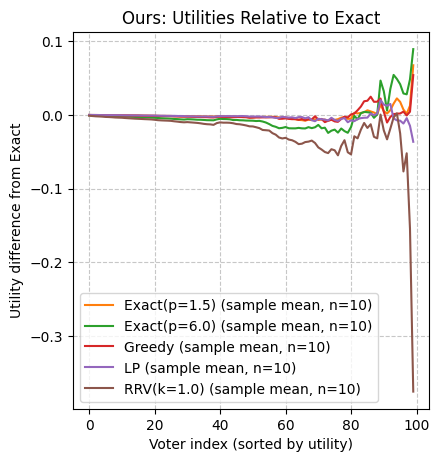

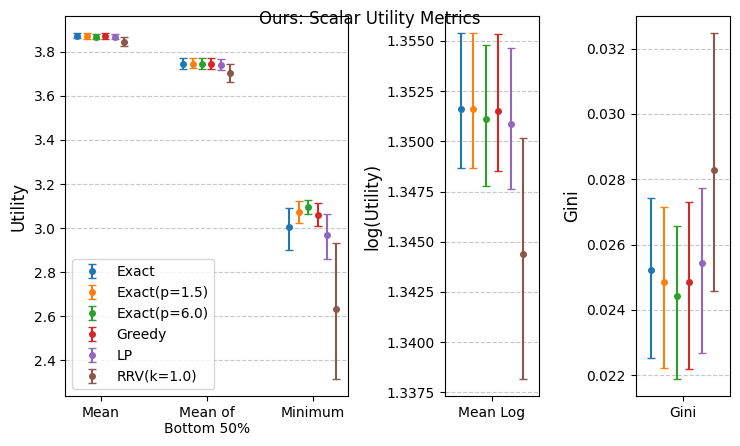

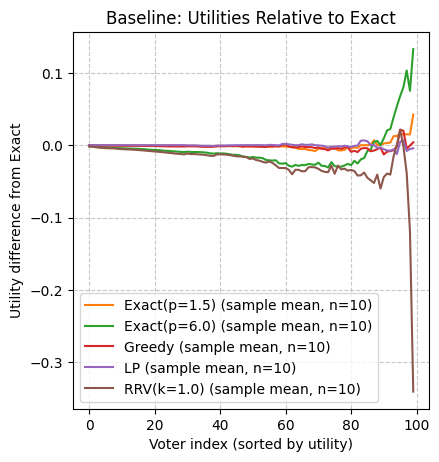

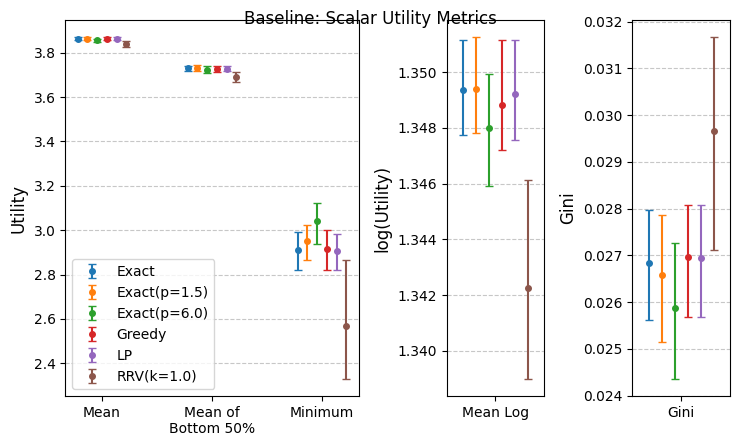

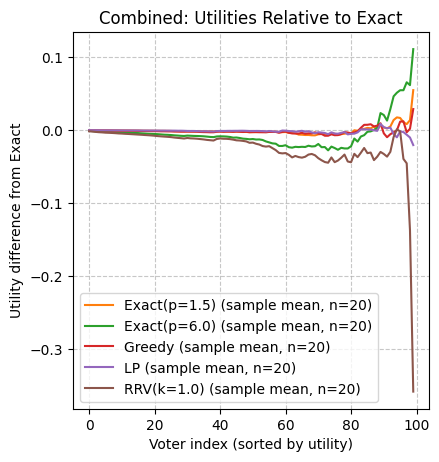

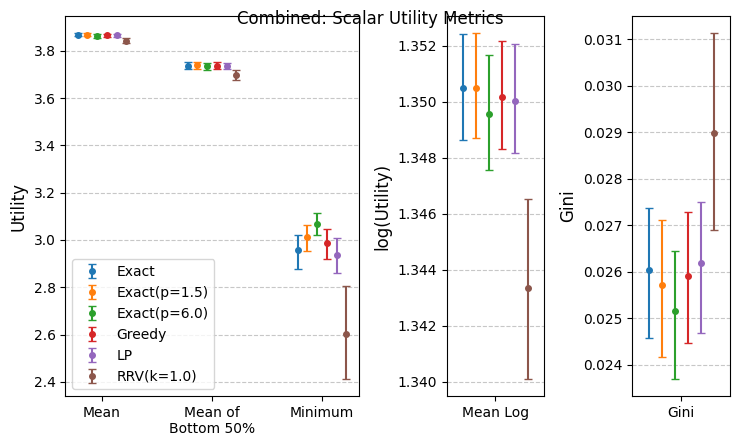

In [27]:

figs = create_all_plots_from_utilities(slate3_utilities_ours, slate3_utilities_baseline, algs=ALGOS_TO_PLOT, which_plots=WHICH_PLOTS)

## Slate 5

In [ ]:
slate5_utilities_ours, slate5_utilities_baseline = vote_baseline_and_ours(
    voting_algorithms_to_test,
    df_ours,
    df_baseline,
    slate_size=5,
)

G:\Other computers\My Computer\NTFS\dev\generative_social_choice\generative_social_choice\utils\postprocessing.py:298: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  group_array = group_data.values
G:\Other computers\My Computer\NTFS\dev\generative_social_choice\generative_social_choice\utils\postprocessing.py:298: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  group_array = group_data.values
G:\Other computers\My Computer\NTFS\dev\generative_social_choice\generative_social_choice\utils\postprocessing.py:298: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future versi

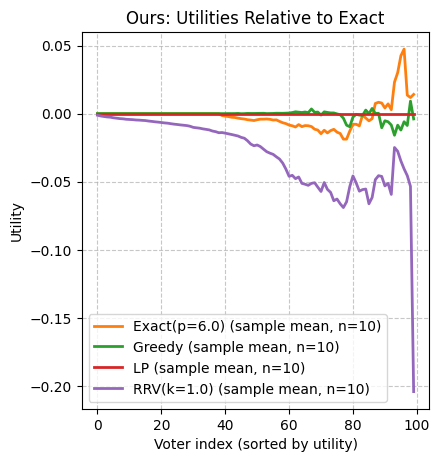

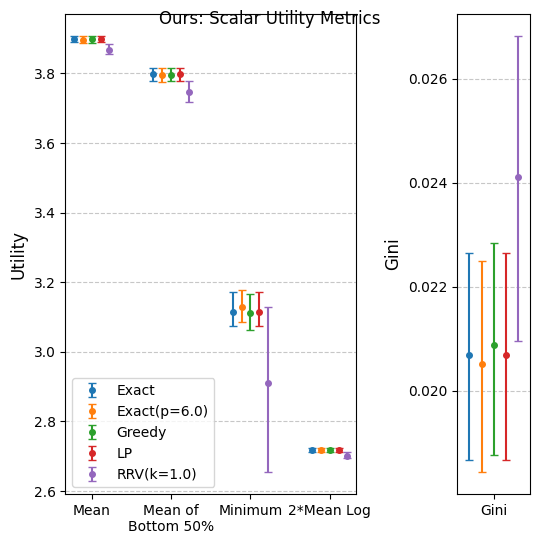

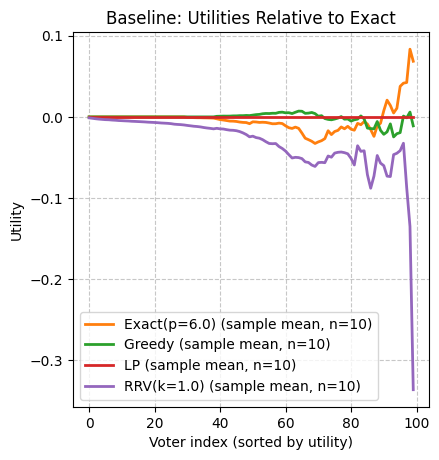

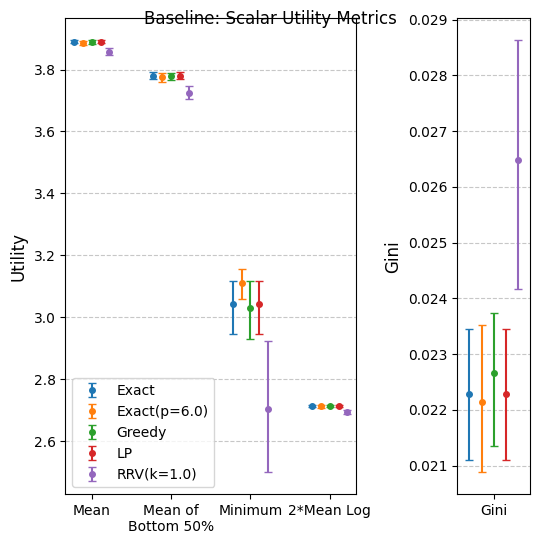

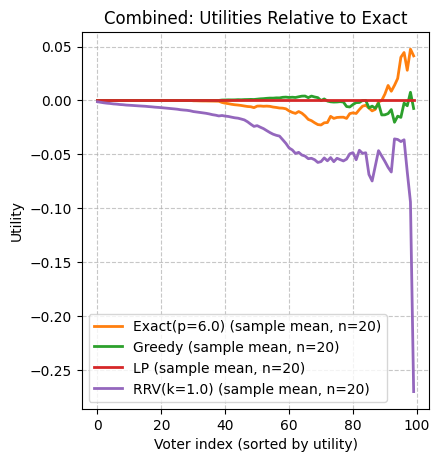

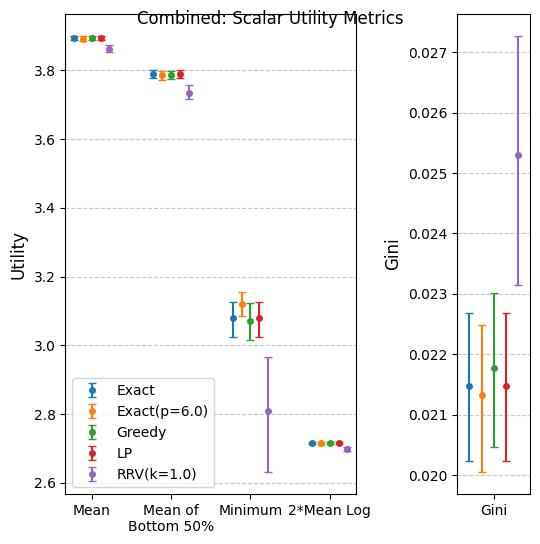

In [69]:
create_all_plots_from_utilities(slate5_utilities_ours, slate5_utilities_baseline, algs=ALGOS_TO_PLOT, which_plots=WHICH_PLOTS)



## Slate 8

In [ ]:
slate8_utilities_ours, slate8_utilities_baseline = vote_baseline_and_ours(
    voting_algorithms_to_test,
    df_ours,
    df_baseline,
    slate_size=8,
)

G:\Other computers\My Computer\NTFS\dev\generative_social_choice\generative_social_choice\utils\postprocessing.py:298: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  group_array = group_data.values
G:\Other computers\My Computer\NTFS\dev\generative_social_choice\generative_social_choice\utils\postprocessing.py:298: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future version. To keep indexes as scalars, create Groupby objects with a scalar level parameter instead.
  group_array = group_data.values
G:\Other computers\My Computer\NTFS\dev\generative_social_choice\generative_social_choice\utils\postprocessing.py:298: FutureWarning: Creating a Groupby object with a length-1 list-like level parameter will yield indexes as tuples in a future versi

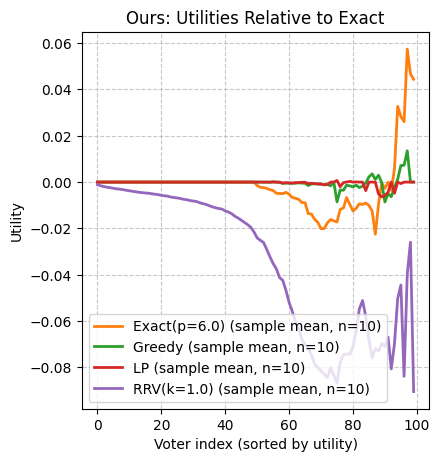

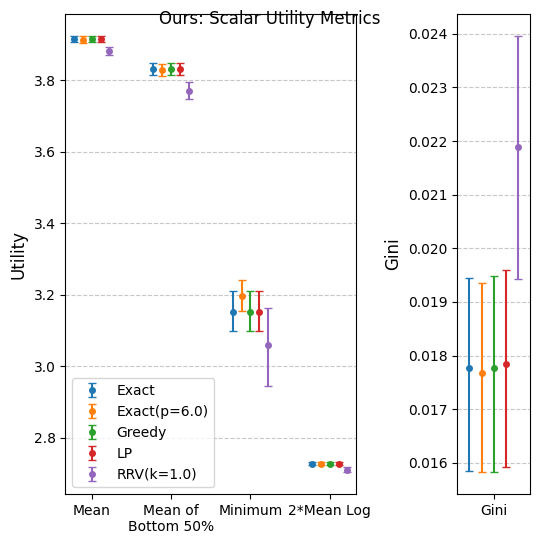

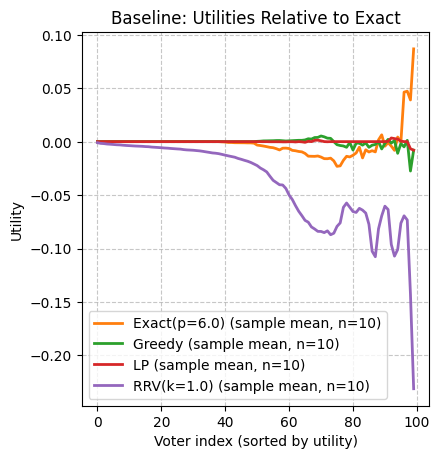

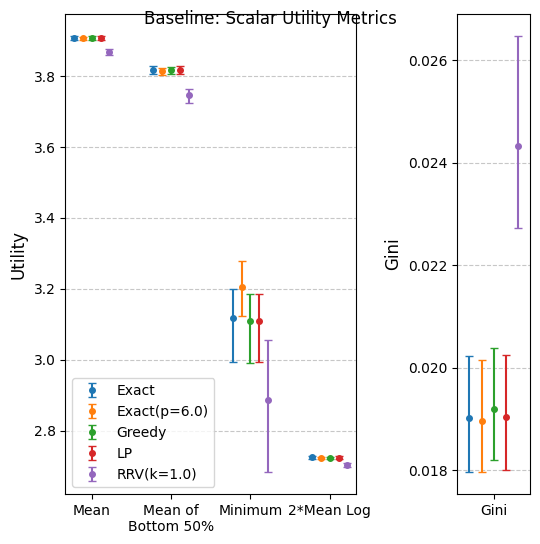

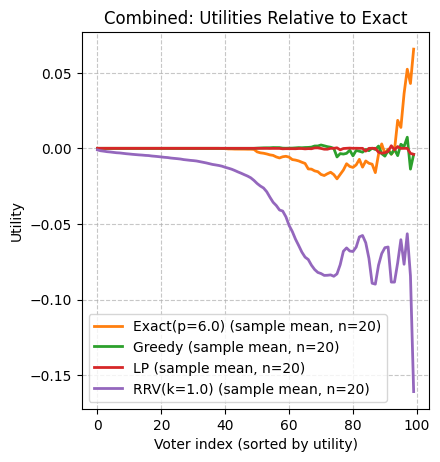

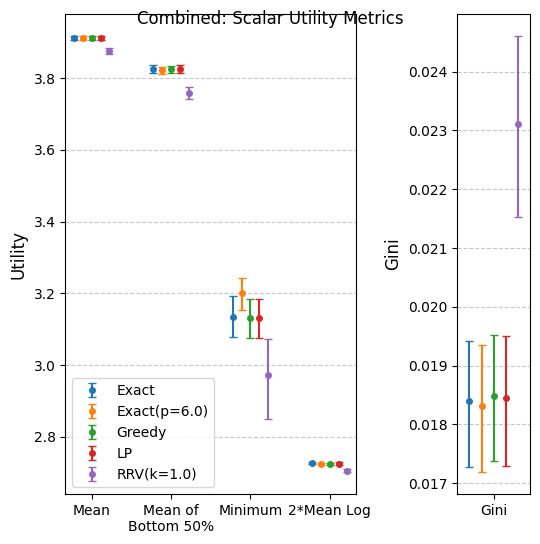

In [70]:
create_all_plots_from_utilities(slate8_utilities_ours, slate8_utilities_baseline, algs=ALGOS_TO_PLOT, which_plots=WHICH_PLOTS)

